In [5]:
import sys  
sys.path.insert(0, './Moduulit (.py)')
pd.options.mode.chained_assignment = None
# Importtaus tässä muodossa
from database_connection import database_query
from outliers import find_outliers, draw_histogram
from clean_dataframe import *
from write_df_to_database import write_df_to_mariadb
from xy_diskretisointi import xy_to_grid
from isolation_forest import *
# tai from ... import *


# Jos datasetti on "df"

# Esim. find_outliers(df)
# Esim. draw_histogram(df['x'], df['y'], 20) <-- kolmas meinaa bins arvoa, eli histogrammin "rakeisuutta"

In [7]:
df = database_query("SELECT * FROM SensorData LIMIT 1000000;")
df.head(5)

,node_id,timestamp,x,y,z,q
0,b'-2393099149039893833',b'2020-06-24 12:20:08.533016+00:00',2762,-257,100,0
1,b'-2393099149039893833',b'2020-06-24 12:20:08.620015+00:00',2870,-344,100,0
2,b'-2393099149039893833',b'2020-06-24 12:20:09.622827+00:00',2916,-344,100,0
3,b'-2393099149039893833',b'2020-06-24 12:20:09.622846+00:00',2894,-254,100,0
4,b'-2393099149039893833',b'2020-06-24 12:20:10.116102+00:00',2888,-188,100,0


# Histogrammi datasta

x mean:  2007.42516
y mean:  524.458634
x std:  880.5673627763946
y std:  1056.1131432857248


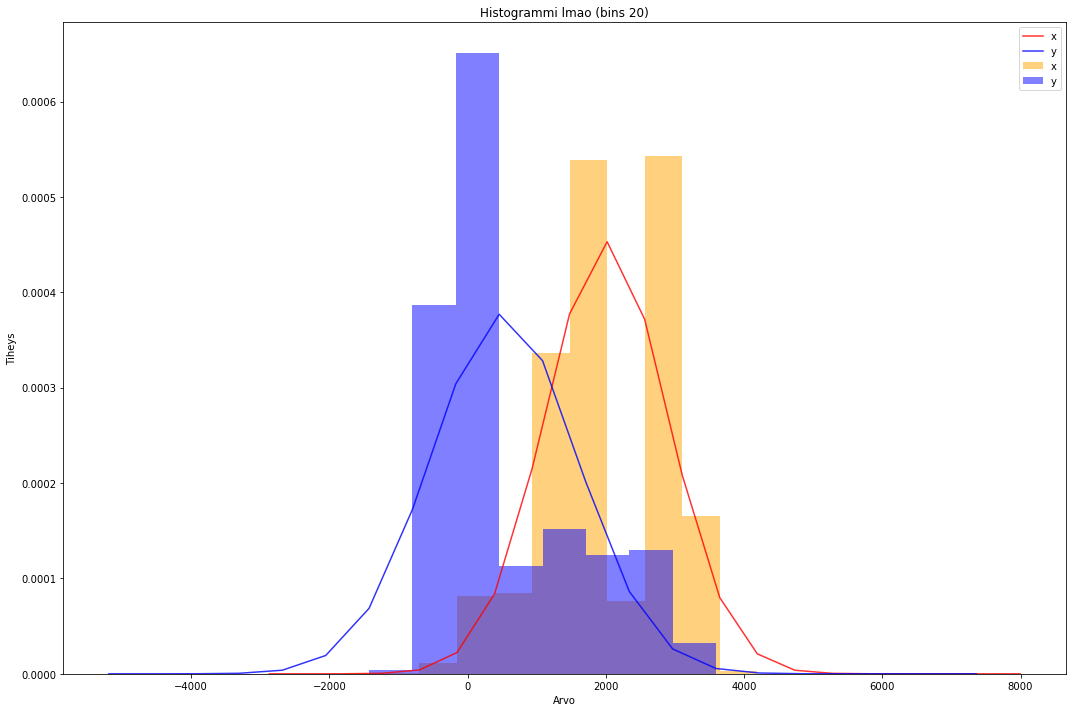

In [8]:
draw_histogram(df['x'], df['y'], 20)

# Finding outliers using z_score

Number of missing variables in table
 node_id      0
timestamp    0
x            0
y            0
z            0
q            0
dtype: int64
------------------------------
Unique values in columns

uniques in x 5161
uniques in y 5033
uniques in z 1
uniques in q 1
------------------------------
Checking z and q columns

uniques in z [100]
uniques in q [0]
------------------------------
Number of nodes: 3
------------------------------
Outliers

Data with outliers:  1000000
Ouliers removed:     6483
Data after:  993517


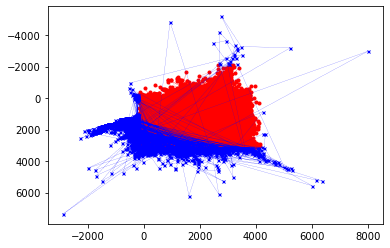

In [9]:
df1 = find_outliers(df)

# Finding outliers using Isolation Forest
- isolation_forest(df, max_samples, random_state, contamination)

In [ ]:
df1 = isolation_forest(df1,800000,0,.2)

In [10]:
df1 = xy_to_grid(df1, df1.x, df1.y, 50)
df1

,node_id,timestamp,x,y,z,q,xy_grid
845826,b'-2393099149039893848',b'2020-06-26 16:04:51.64462+00:00',-141,-369,100,0,1
666394,b'-2393099149039893844',b'2020-07-12 07:05:35.793124+00:00',-192,-217,100,0,2
446989,b'-2393099149039893833',b'2020-10-01 12:20:04.062193+00:00',-156,-171,100,0,3
666396,b'-2393099149039893844',b'2020-07-12 07:05:36.793162+00:00',-140,-209,100,0,3
666397,b'-2393099149039893844',b'2020-07-12 07:05:44.793342+00:00',-107,-178,100,0,3
...,...,...,...,...,...,...,...
74819,b'-2393099149039893833',b'2020-07-12 17:44:43.793312+00:00',631,3061,100,0,1821
156812,b'-2393099149039893833',b'2020-07-31 17:03:49.793577+00:00',599,3062,100,0,1821
389205,b'-2393099149039893833',b'2020-09-22 14:33:33.037216+00:00',626,3094,100,0,1821
83774,b'-2393099149039893833',b'2020-07-14 15:56:27.793541+00:00',626,3071,100,0,1821
